In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import os.path as path
import os
os.environ['OMP_NUM_THREADS'] = '2'

import lib.dist as dist
import lib.utils as utils


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix', 
    'xtick.labelsize' : 13,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.labelsize' : 13, 
    'ytick.right' : True, 
    'axes.labelsize' : 16,
    'legend.frameon': False,
    'legend.fontsize': 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 300,
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
torch.__version__

'1.7.1'

In [43]:
b = 60
latent_dim = 8
h_node = 10
beta = 4
prior_dist = dist.Normal()
q_dist = dist.Normal()
t_len = 100

prefix = '../1_QMC/train' #'./Hirsch-Fye-QMC'
txt = np.loadtxt(prefix + f'/Bethe_14_beta{b:d}/field-2.10.dat')
s_tot, s_len = txt.shape
print("txt.shape =", s_tot, s_len)
s_train = 15
s_test = 15
s_num = 30
t_len = 100

U = np.array([0.01*i for i in range(100, 401)])
U_up, U_dn = [], []
for i, u in enumerate(U):
    if path.isfile(prefix + f'/Bethe_14_beta{b:d}/field-{u:.2f}.dat')==True: U_up.append(u)
    if path.isfile(prefix + f'/Bethe_41_beta{b:d}/field-{u:.2f}.dat')==True: U_dn.append(u)
U_up = np.array(U_up)
U_dn = np.array(U_dn)

txt.shape = 3000 288


In [3]:
LR2_zp_4 = torch.load('frozen/LR2_zp_4.dat')
LR4_zp_4 = torch.load('frozen/LR4_zp_4.dat')
LR8_zp_4 = torch.load('frozen/LR8_zp_4.dat')
NN10_zp_4 = torch.load('frozen/NN10_zp_4.dat')
NN100_zp_4 = torch.load('frozen/NN100_zp_4.dat')
NN200_zp_4 = torch.load('frozen/NN200_zp_4.dat')

LR2_zp_5 = torch.load('frozen/LR2_zp_5.dat')
LR4_zp_5 = torch.load('frozen/LR4_zp_5.dat')
LR8_zp_5 = torch.load('frozen/LR8_zp_5.dat')
NN10_zp_5 = torch.load('frozen/NN10_zp_5.dat')
NN100_zp_5 = torch.load('frozen/NN100_zp_5.dat')
NN200_zp_5 = torch.load('frozen/NN200_zp_5.dat')

zp_4 = [LR2_zp_4, LR4_zp_4, LR8_zp_4, NN10_zp_4, NN100_zp_4, NN200_zp_4]
zp_5 = [LR2_zp_5, LR4_zp_5, LR8_zp_5, NN10_zp_5, NN100_zp_5, NN200_zp_5]
zp_4.reverse(), zp_5.reverse()

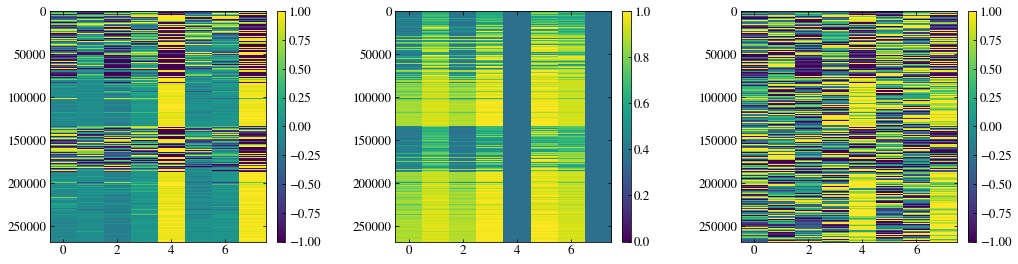

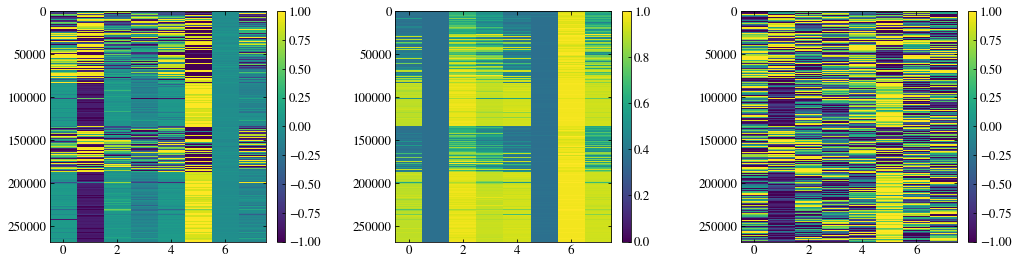

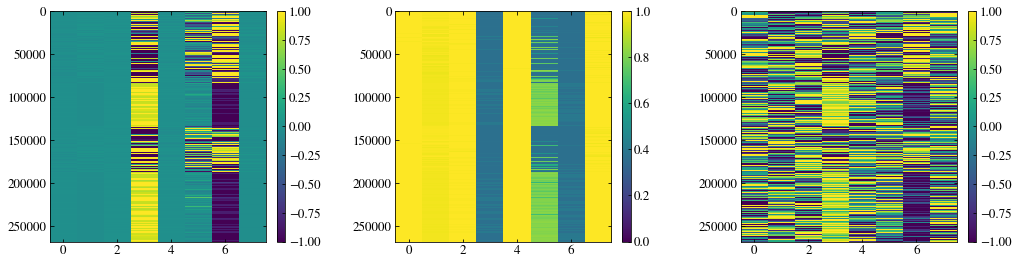

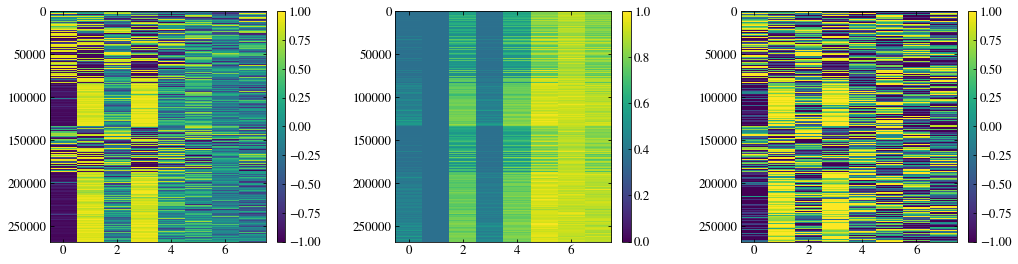

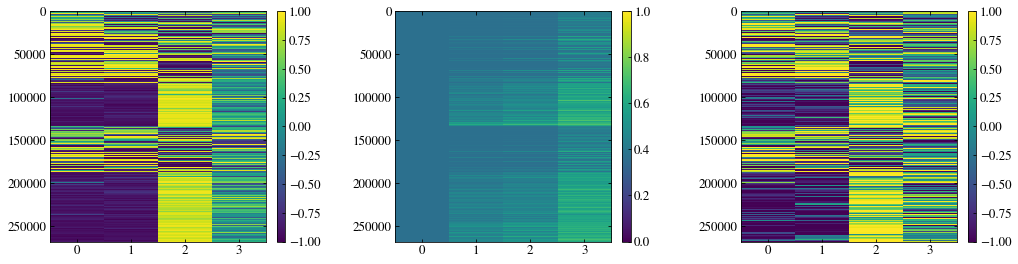

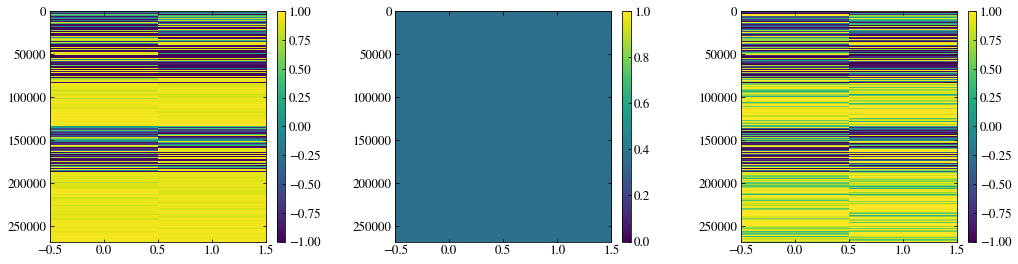

In [7]:
for z_params in zp_4:
    ax[0] = plt.axes([0, 0, 0.5, 0.8])
    ax[1] = plt.axes([0.8, 0, 0.5, 0.8])
    ax[2] = plt.axes([1.6, 0, 0.5, 0.8])
    mu = z_params.detach().numpy()[:,:,0]
    im = ax[0].imshow(mu, **{'vmin':-1.0, 'vmax':1.0}, aspect='auto', interpolation='none')
    ca=inset_axes(ax[0], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)

    sig = np.exp(z_params.detach().numpy()[:,:,1])
    im = ax[1].imshow(sig, **{'vmin':0.0, 'vmax':1.0}, aspect='auto', interpolation='none')
    ca=inset_axes(ax[1], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)
    
    sample = torch.randn(mu.shape)*sig + mu
    im = ax[2].imshow(sample, **{'vmin':-1.0, 'vmax':1.0}, aspect='auto', interpolation='none')
    ca=inset_axes(ax[2], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[2].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)
    plt.show()
    plt.show()

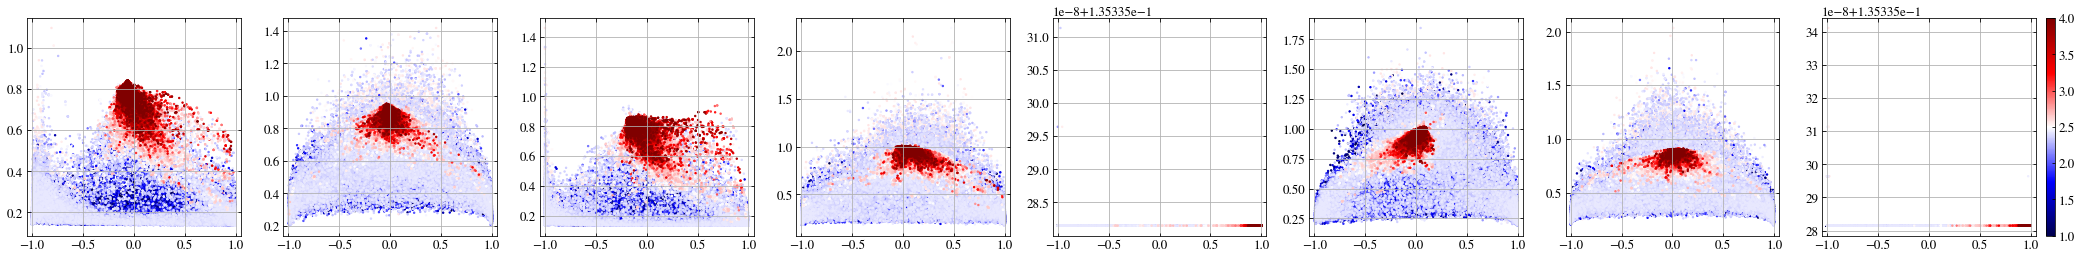

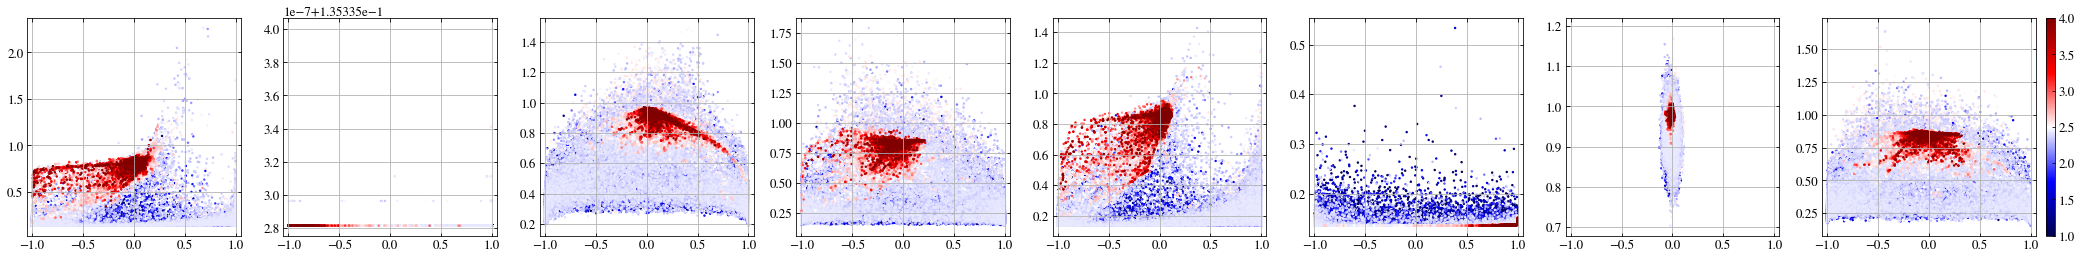

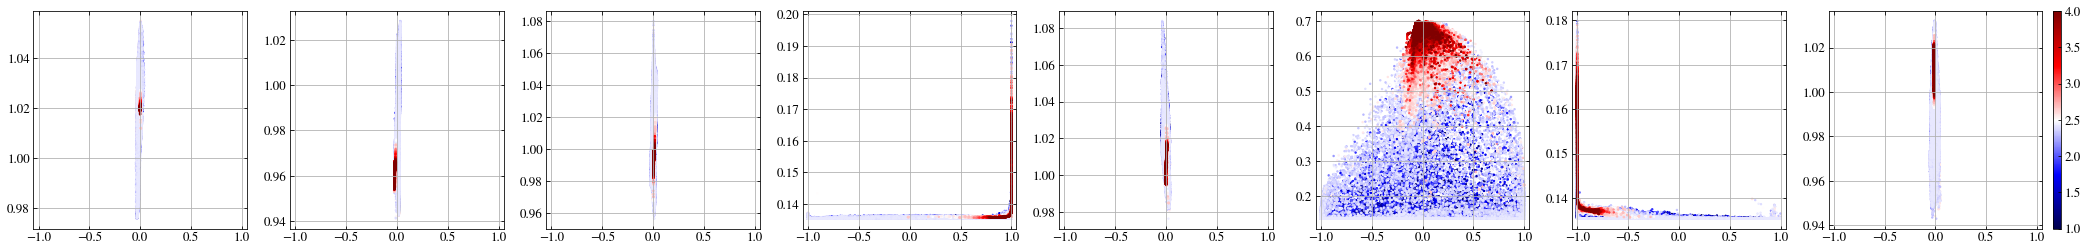

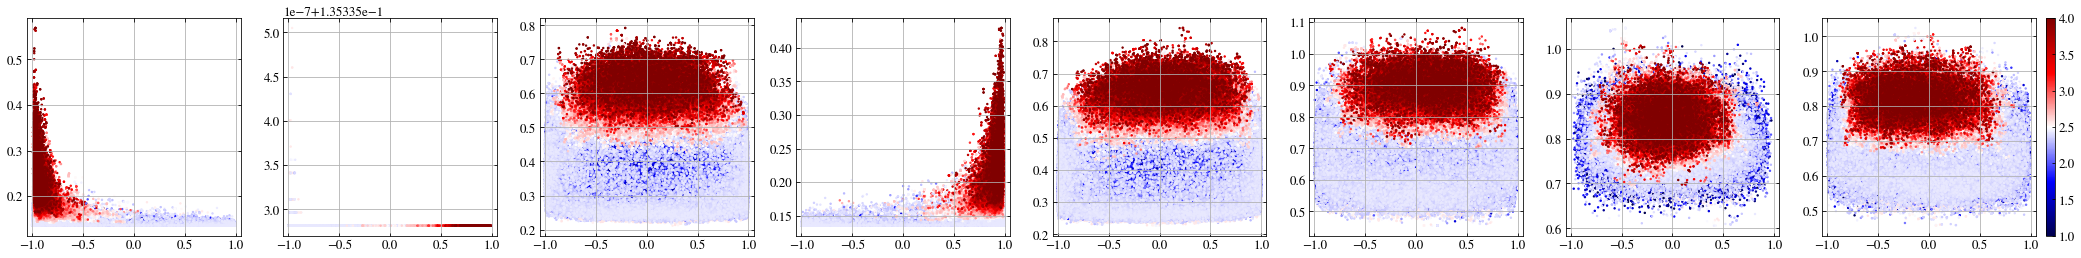

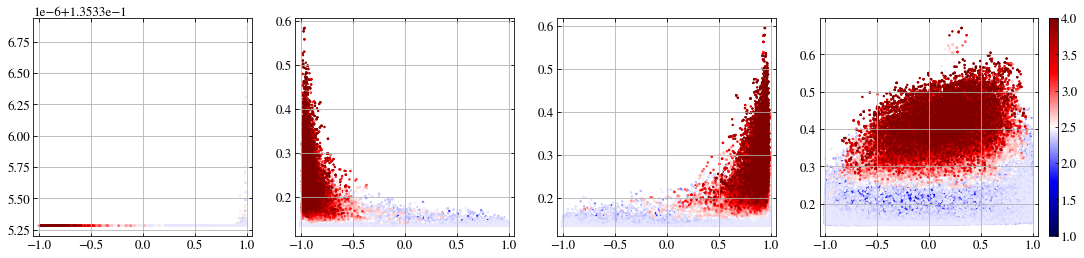

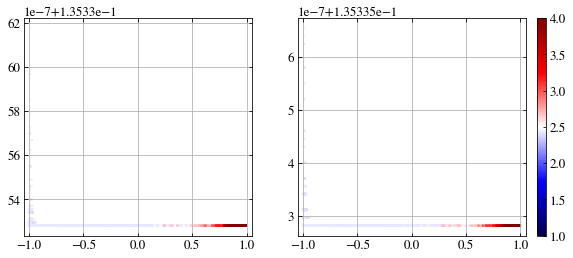

In [8]:
for z_params in zp_4:
    if z_params is LR2_zp_4: ldim = 2
    elif z_params is LR4_zp_4: ldim = 4
    else: ldim = 8
    
    zp_mu = z_params[:, :, 0].detach().numpy()
    zp_logsig = z_params[:, :, 1].detach().numpy()
    zp_var = np.exp(zp_logsig * 2)
    U = np.repeat(np.concatenate([U_up, U_dn]), 2000)
    
    '''
    pca1 = PCA(n_components=1)
    pca1.fit(zp_mu)
    pca_mu = pca1.transform(zp_mu)
    pca2 = PCA(n_components=1)
    pca2.fit(zp_var)
    pca_var = pca2.transform(zp_var)'''

    fig, ax = plt.subplots(1, ldim, figsize = (ldim*4.5,4))

    for i in range (ldim):
        im = ax[i].scatter(zp_mu[:,i], zp_var[:,i], s=2, c = U, cmap = 'seismic')
        ax[i].grid()
        ax[i].set_xlim(-1.05, 1.05)
    ca=inset_axes(ax[i], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[i].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)
    plt.show()

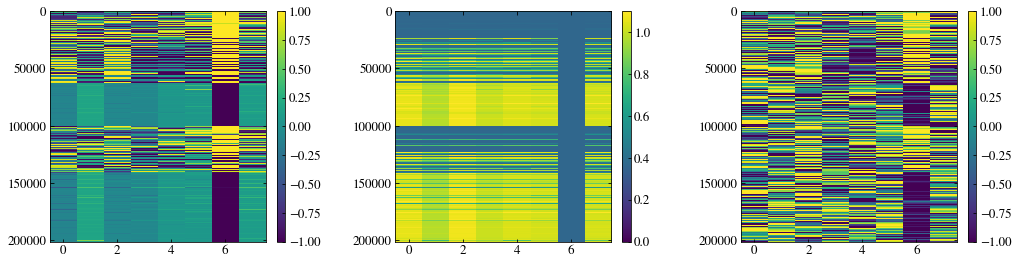

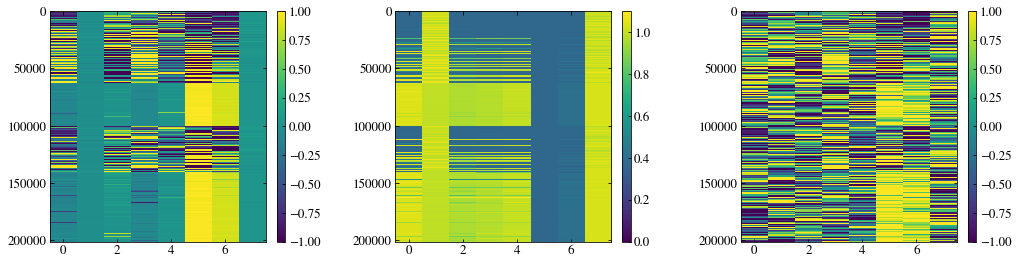

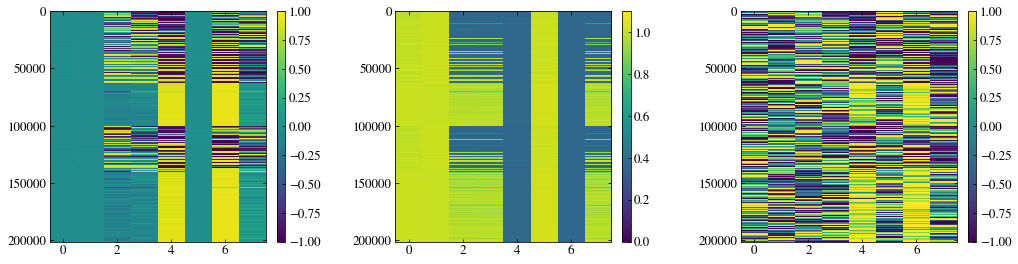

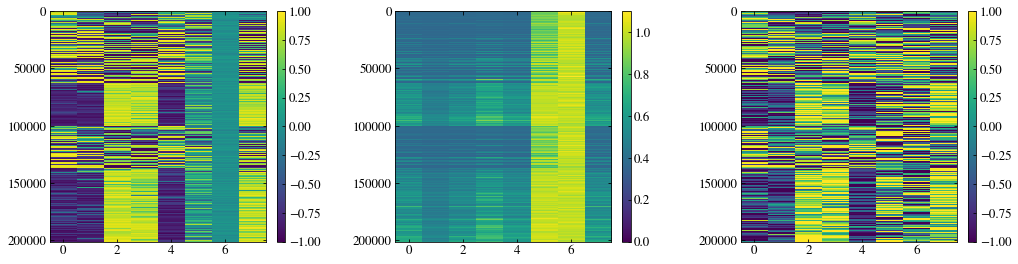

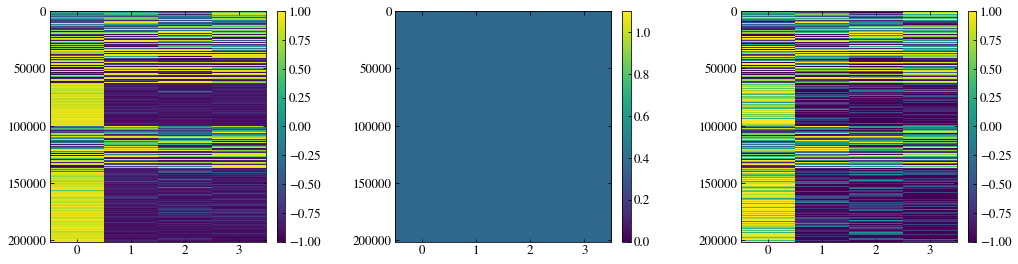

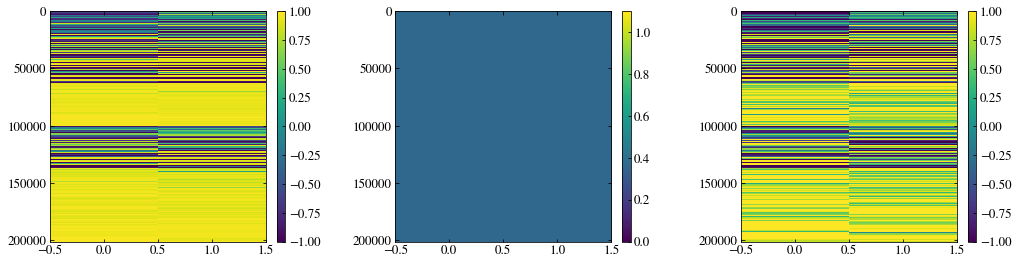

In [11]:
for z_params in zp_5:
    if z_params is LR2_zp_5: ldim = 2
    elif z_params is LR4_zp_5: ldim = 4
    else: ldim = 8
    ax[0] = plt.axes([0, 0, 0.5, 0.8])
    ax[1] = plt.axes([0.8, 0, 0.5, 0.8])
    ax[2] = plt.axes([1.6, 0, 0.5, 0.8])
    
    mu = z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,0]
    im = ax[0].imshow(mu, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='none')
    ca=inset_axes(ax[0], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)

    sig = np.exp(z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,1])
    im = ax[1].imshow(sig, **{'vmin':0.0, 'vmax':1.1},\
                      aspect='auto', interpolation='none')
    ca=inset_axes(ax[1], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)
    
    sample = torch.randn(mu.shape)*sig + mu
    im = ax[2].imshow(sample, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='none')
    ca=inset_axes(ax[2], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[2].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (100500,) and torch.Size([201000, 8])

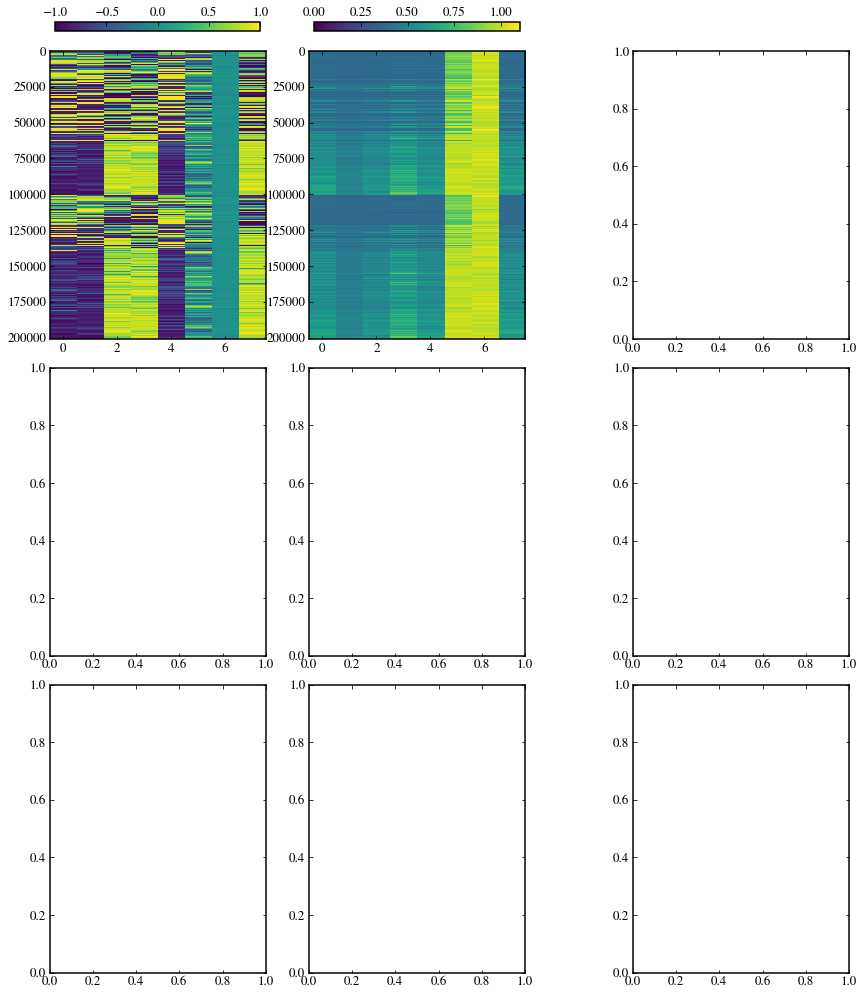

In [155]:
axs0 = plt.axes([0.0, 0.0, 0.5, 1.0])
axs1 = plt.axes([0.6, 0.0, 0.5, 1.0])
axs2 = plt.axes([1.35, 0.0, 0.5, 1.0])
axs3 = plt.axes([0.0, 1.1, 0.5, 1.0])
axs4 = plt.axes([0.6, 1.1, 0.5, 1.0])
axs5 = plt.axes([1.35, 1.1, 0.5, 1.0])
axs6 = plt.axes([0.0, 2.2, 0.5, 1.0])
axs7 = plt.axes([0.6, 2.2, 0.5, 1.0])
axs8 = plt.axes([1.35, 2.2, 0.5, 1.0])
ax = [axs0, axs1, axs2, axs3, axs4, axs5, axs6, axs7, axs8]

for i, z_params in enumerate(zp_5[3:]):
    if z_params is LR2_zp_5: ldim = 2
    elif z_params is LR4_zp_5: ldim = 4
    else: ldim = 8
    
    mu = z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,0]
    im = ax[6-3*i+0].imshow(mu, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='none')
    if i==0:
        ca=inset_axes(ax[6-3*i+0], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+0].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()

    sig = np.exp(z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,1])
    im = ax[6-3*i+1].imshow(sig, **{'vmin':0.0, 'vmax':1.1},\
                      aspect='auto', interpolation='none')
    if i==0:
        ca=inset_axes(ax[6-3*i+1], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+1].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()
    
    sample = torch.randn(mu.shape)*sig + mu
    ax[6-3*i+2].plot(np.repeat(U_up, 1500), sample[:1005000], 'b.')
    ax[6-3*i+2].plot(np.repeat(U_dn, 1500), sample[1005000:], 'k.')
    if i==0:
        ca=inset_axes(ax[6-3*i+2], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+2].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()
        
for i in range(3):
    ax[i].set_xticks([0,1])
    
for i, axs in enumerate(ax):
    axs.axhline(100500, c='k', lw='1.5')
    if i%3==0:
        a = [10000, 35000, 65000, 90000, 110500, 135500, 165500, 190500]
        axs.set_yticks(a)
        axs.set_yticklabels(UU[a])
        axs.annotate(r'$U\uparrow$', xy=(-0.2, 0.75), xycoords = 'axes fraction', fontsize = 20, ha = 'center')
        axs.annotate(r'$U\downarrow$', xy=(-0.2, 0.25), xycoords = 'axes fraction', fontsize = 20, ha = 'center')
    else:
        axs.set_yticklabels([])
        
plt.gcf().text(-0.17, 3.18, '(a)', fontsize = 22)
plt.gcf().text(-0.17, 2.08, '(b)', fontsize = 22)
plt.gcf().text(-0.17, 0.98, '(c)', fontsize = 22)
plt.gcf().text(1.25, 3.18, '(d)', fontsize = 22)
plt.gcf().text(1.25, 2.08, '(e)', fontsize = 22)
plt.gcf().text(1.25, 0.98, '(f)', fontsize = 22)

ax[0].set_xlabel(r'latent node ($\mu$)', fontsize = 22)
ax[1].set_xlabel(r'latent node ($\sigma$)', fontsize = 22)
ax[2].set_xlabel(r'latent node ($z$)', fontsize = 22)

ax[1].annotate('', xy=(1.4,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})
ax[4].annotate('', xy=(1.4,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})
ax[7].annotate('', xy=(1.4,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})


#plt.savefig('fig/fig_zparams.png')

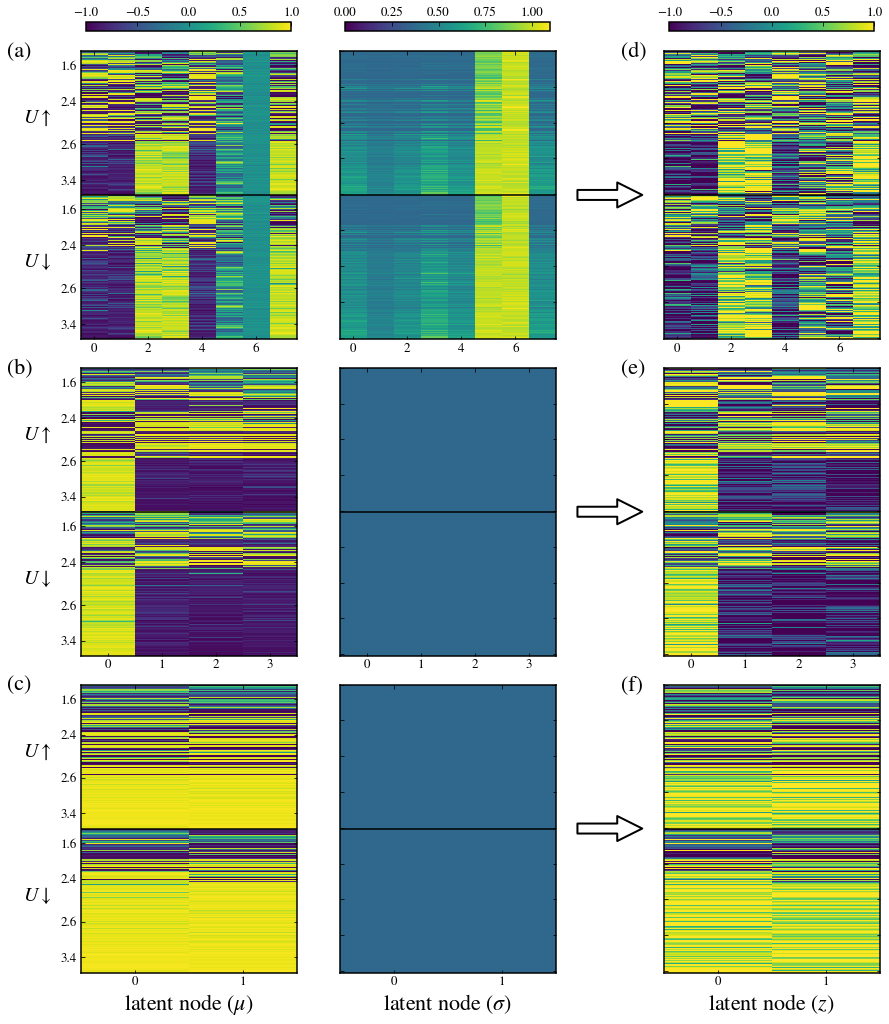

In [145]:
axs0 = plt.axes([0.0, 0.0, 0.5, 1.0])
axs1 = plt.axes([0.6, 0.0, 0.5, 1.0])
axs2 = plt.axes([1.35, 0.0, 0.5, 1.0])
axs3 = plt.axes([0.0, 1.1, 0.5, 1.0])
axs4 = plt.axes([0.6, 1.1, 0.5, 1.0])
axs5 = plt.axes([1.35, 1.1, 0.5, 1.0])
axs6 = plt.axes([0.0, 2.2, 0.5, 1.0])
axs7 = plt.axes([0.6, 2.2, 0.5, 1.0])
axs8 = plt.axes([1.35, 2.2, 0.5, 1.0])
ax = [axs0, axs1, axs2, axs3, axs4, axs5, axs6, axs7, axs8]

for i, z_params in enumerate(zp_5[3:]):
    if z_params is LR2_zp_5: ldim = 2
    elif z_params is LR4_zp_5: ldim = 4
    else: ldim = 8
    
    mu = z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,0]
    im = ax[6-3*i+0].imshow(mu, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='none')
    if i==0:
        ca=inset_axes(ax[6-3*i+0], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+0].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()

    sig = np.exp(z_params.reshape(2010*100,ldim,2).detach().numpy()[:,:,1])
    im = ax[6-3*i+1].imshow(sig, **{'vmin':0.0, 'vmax':1.1},\
                      aspect='auto', interpolation='none')
    if i==0:
        ca=inset_axes(ax[6-3*i+1], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+1].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()
    
    sample = torch.randn(mu.shape)*sig + mu
    im = ax[6-3*i+2].imshow(sample, **{'vmin':-1.0, 'vmax':1.0},\
                      aspect='auto', interpolation='none')
    if i==0:
        ca=inset_axes(ax[6-3*i+2], width="100%", height="3%", loc='lower center',\
                   bbox_to_anchor=(0.025, 1.07, 0.95, 1), bbox_transform=ax[6-3*i+2].transAxes, borderpad=0)
        cd = plt.colorbar(im, cax = ca, orientation = 'horizontal')
        cd.ax.xaxis.tick_top()
        
for i in range(3):
    ax[i].set_xticks([0,1])
    
for i, axs in enumerate(ax):
    axs.axhline(100500, c='k', lw='1.5')
    if i%3==0:
        a = [10000, 35000, 65000, 90000, 110500, 135500, 165500, 190500]
        axs.set_yticks(a)
        axs.set_yticklabels(UU[a])
        axs.annotate(r'$U\uparrow$', xy=(-0.2, 0.75), xycoords = 'axes fraction', fontsize = 20, ha = 'center')
        axs.annotate(r'$U\downarrow$', xy=(-0.2, 0.25), xycoords = 'axes fraction', fontsize = 20, ha = 'center')
    else:
        axs.set_yticklabels([])
        
plt.gcf().text(-0.17, 3.18, '(a)', fontsize = 22)
plt.gcf().text(-0.17, 2.08, '(b)', fontsize = 22)
plt.gcf().text(-0.17, 0.98, '(c)', fontsize = 22)
plt.gcf().text(1.25, 3.18, '(d)', fontsize = 22)
plt.gcf().text(1.25, 2.08, '(e)', fontsize = 22)
plt.gcf().text(1.25, 0.98, '(f)', fontsize = 22)

ax[0].set_xlabel(r'latent node ($\mu$)', fontsize = 22)
ax[1].set_xlabel(r'latent node ($\sigma$)', fontsize = 22)
ax[2].set_xlabel(r'latent node ($z$)', fontsize = 22)

ax[1].annotate('', xy=(1.4,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})
ax[4].annotate('', xy=(1.4,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})
ax[7].annotate('', xy=(1.4,0.5), xytext=(1.1,0.5), xycoords = 'axes fraction', ha='center', va='center',\
            arrowprops={'arrowstyle':'simple', 'shrinkA':0, 'shrinkB':0,'lw':2, \
                        'mutation_scale':50, 'fc':'None', 'ec':'k'})


#plt.savefig('fig/fig_zparams.png')

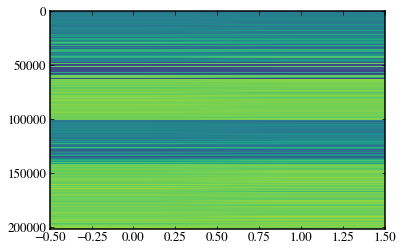

In [153]:
a = F.logsigmoid(sample) - F.logsigmoid(-sample) \
    + torch.log(torch.rand(sample.size()) + 1e-8) - torch.log(1-torch.rand(sample.size())+1e-8)
aa = torch.zeros(a.size())
aa[a>=0] = 1
plt.imshow(aa, aspect='auto')

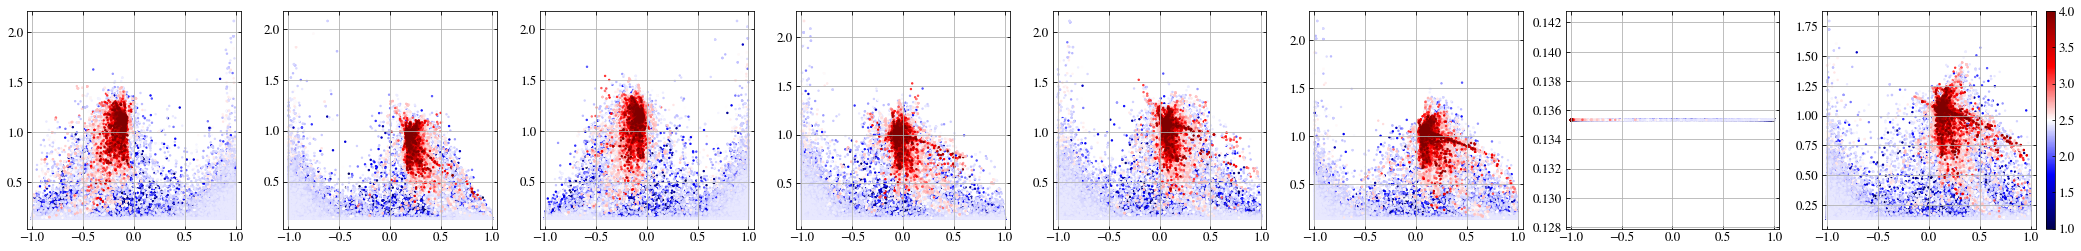

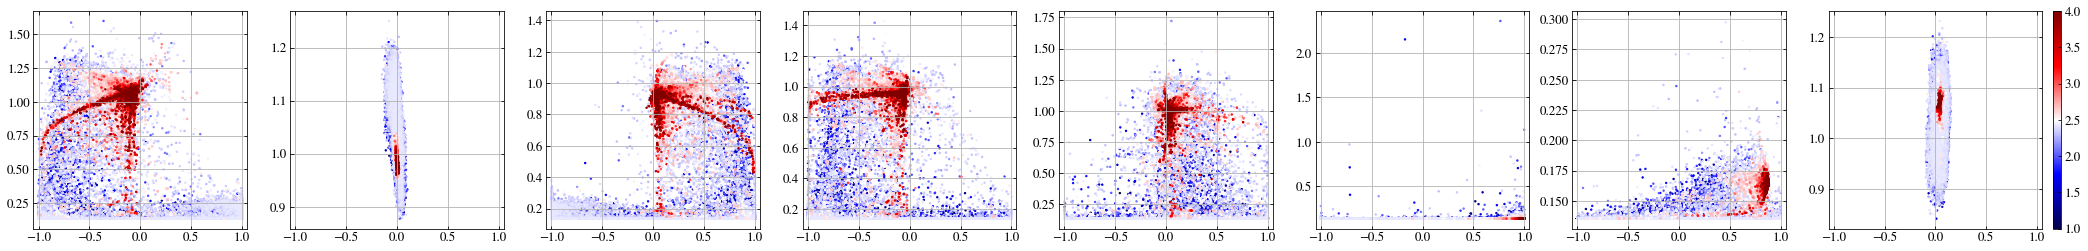

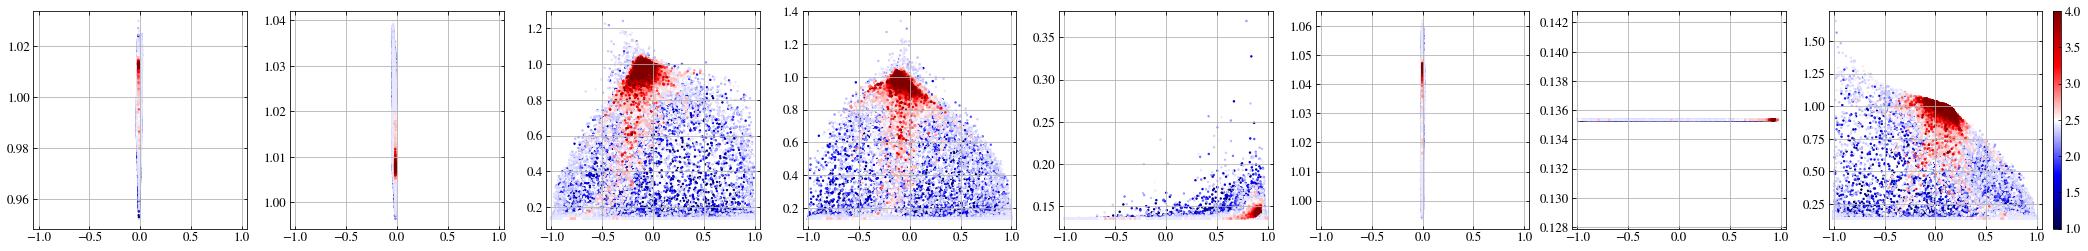

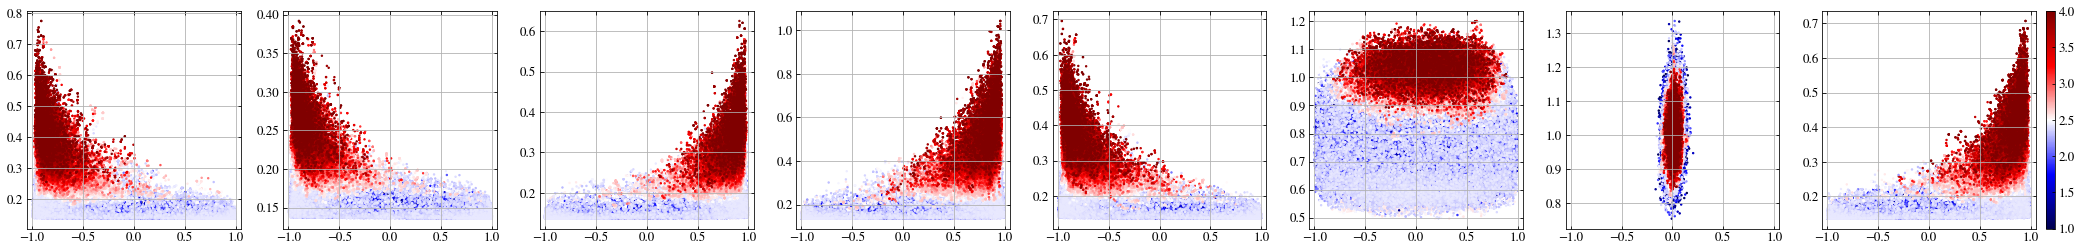

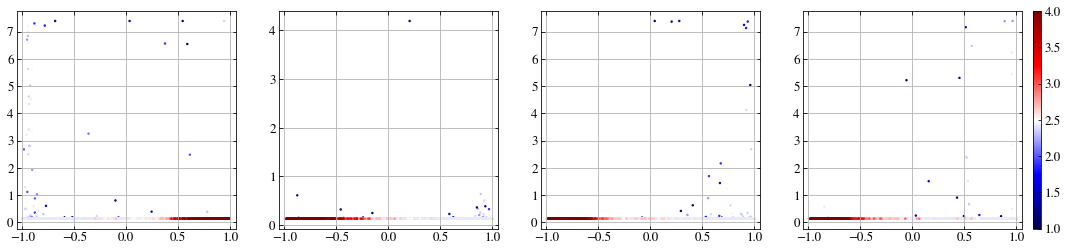

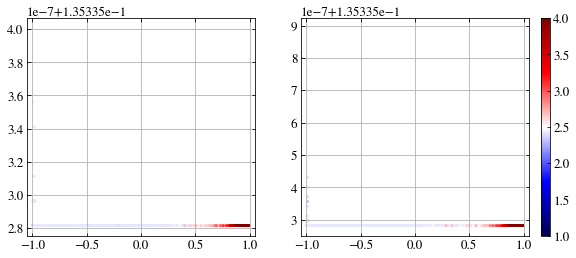

In [12]:
for z_params in zp_5:
    if z_params is LR2_zp_5: ldim = 2
    elif z_params is LR4_zp_5: ldim = 4
    else: ldim = 8
    
    zp_mu = z_params.reshape(2010*100, ldim, 2)[:, :, 0].detach().numpy()
    zp_logsig = z_params.reshape(2010*100, ldim, 2)[:, :, 1].detach().numpy()
    zp_var = np.exp(zp_logsig * 2)
    UU = np.repeat(np.concatenate([U_up, U_dn]), 1500)
    
    '''
    pca1 = PCA(n_components=1)
    pca1.fit(zp_mu)
    pca_mu = pca1.transform(zp_mu)
    pca2 = PCA(n_components=1)
    pca2.fit(zp_var)
    pca_var = pca2.transform(zp_var)'''

    fig, ax = plt.subplots(1, ldim, figsize = (ldim*4.5,4))

    for i in range (ldim):
        im = ax[i].scatter(zp_mu[:,i], zp_var[:,i], s=2, c = UU, cmap = 'seismic')
        ax[i].grid()
        ax[i].set_xlim(-1.05, 1.05)
    ca=inset_axes(ax[i], width="5%", height="100%", loc='center left',\
                   bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[i].transAxes, borderpad=0)
    cd = plt.colorbar(im, cax = ca)
    plt.show()

In [ ]:
pca1 = PCA(n_components=2), pca1.fit(zp_mu)
pca_mu = pca1.transform(zp_mu)
pca2 = PCA(n_components=2), pca2.fit(zp_var)
pca_var = pca2.transform(zp_var)

In [17]:
class NEncoder(nn.Module):
    def __init__(self, output_dim):
        super(NEncoder, self).__init__()
        self.output_dim = output_dim

        self.L1 = nn.Linear(s_len, output_dim)
        #self.b1 = nn.Linear(output_dim, 1, bias=False)

        # setup the non-linearity
        #self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        #self.b1.weight.data.fill_(0)

    def forward(self, x):
        h = x.view(-1, t_len, s_len)
        z = (self.L1(h)).view(x.size(0), t_len, self.output_dim)
        return z

class NDecoder(nn.Module):
    def __init__(self, input_dim):
        super(NDecoder, self).__init__()
        self.L1 = nn.Linear(input_dim, s_len)
        #self.b1 = nn.Linear(s_len, 1, bias=False)

        # setup the non-linearity
        #self.act = nn.Tanh()
        self.sig = nn.Sigmoid()

        nn.init.xavier_normal_(self.L1.weight)
        #self.b1.weight.data.fill_(0)

    def forward(self, z):
        h = z.view(z.size(0), z.size(1), z.size(2))
        mu_img = self.sig(self.L1(h))#+self.b1.weight)
        return mu_img

def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

### beta-TCVAE
class TCVAE(nn.Module):
    def __init__(self, z_dim, beta, prior_dist=dist.Normal(), q_dist=dist.Normal(),
                 include_mutinfo=True, tcvae=True, mss=True):
        super(TCVAE, self).__init__()

        self.z_dim = z_dim
        self.include_mutinfo = include_mutinfo
        self.tcvae = tcvae
        self.lamb = 0
        self.beta = beta
        self.mss = mss
        self.x_dist = dist.Bernoulli()

        self.prior_dist = prior_dist
        self.q_dist = q_dist
        self.register_buffer('prior_params', torch.zeros(t_len, self.z_dim, 2))

        self.encoder = NEncoder(z_dim * self.q_dist.nparams)
        self.decoder = NDecoder(z_dim)

    def _get_prior_params(self, batch_size=1):
        expanded_size = (batch_size,) + self.prior_params.size()
        prior_params = Variable(self.prior_params.expand(expanded_size))
        return prior_params

    def model_sample(self, batch_size=1):
        prior_params = self._get_prior_params(batch_size)
        zs = self.prior_dist.sample(params=prior_params)
        x_params = self.decoder.forward(zs)
        return x_params

    def encode(self, x):
        x = x.view(x.size(0), 100, s_len)
        z_params = self.encoder.forward(x).view(x.size(0), t_len, self.z_dim, self.q_dist.nparams)
        zs = self.q_dist.sample(params=z_params)
        return zs, z_params

    def decode(self, z):
        x_params = self.decoder.forward(z).view(z.size(0), t_len, s_len)
        xs = self.x_dist.sample(params=x_params)
        return xs, x_params

    def reconstruct_img(self, x):
        zs, z_params = self.encode(x)
        xs, x_params = self.decode(zs)
        return xs, x_params, zs, z_params

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[::M+1] = 1 / N
        W.view(-1)[1::M+1] = strat_weight
        W[M-1, 0] = strat_weight
        return W.log()

    def elbo(self, x, dataset_size):
        batch_size = x.size(0)
        x = x.view(batch_size, 100, s_len)
        prior_params = self._get_prior_params(batch_size)
        x_recon, x_params, zs, z_params = self.reconstruct_img(x)
        logpx = self.x_dist.log_density(x, params=x_params).view(batch_size, -1).sum(1)
        logpz = self.prior_dist.log_density(zs, params=prior_params).view(batch_size, -1).sum(1)
        logqz_condx = self.q_dist.log_density(zs, params=z_params).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx # log p(x|z) + log p(z) - log q(z|x)
        # log q(z) ~ log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))
        _logqz = self.q_dist.log_density(zs.view(batch_size, 1, t_len, self.z_dim),
                                         z_params.view(1, batch_size, t_len, self.z_dim, self.q_dist.nparams))

        if not self.mss: # minibatch weighted sampling
            logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)
            logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
        else: # minibatch stratified sampling
            logiw_matrix = Variable(self._log_importance_weight_matrix(batch_size, dataset_size).type_as(_logqz.data))
            logqz = logsumexp(logiw_matrix + _logqz.sum(3).sum(2), dim = 1, keepdim=False)
            logqz_prodmarginals = logsumexp(
                logiw_matrix.view(batch_size, batch_size, 1) + _logqz.sum(2), dim = 1, keepdim = False).sum(1)

        if self.include_mutinfo:
            elbo2 = logpx - logqz_condx + logqz - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)
        else:
            elbo2 = logpx - self.beta * (logqz - logqz_prodmarginals) - \
                                (1 - self.lamb) * (logqz_prodmarginals - logpz)

        return elbo2, elbo.detach()

latent_dim = 2
model_LR2 = TCVAE(z_dim=latent_dim, beta=beta, prior_dist=prior_dist, q_dist=q_dist)
model_LR2.load_state_dict(torch.load('./frozen/VAE_LR2_5.pth'))   
   


<All keys matched successfully>

torch.Size([201000, 288])

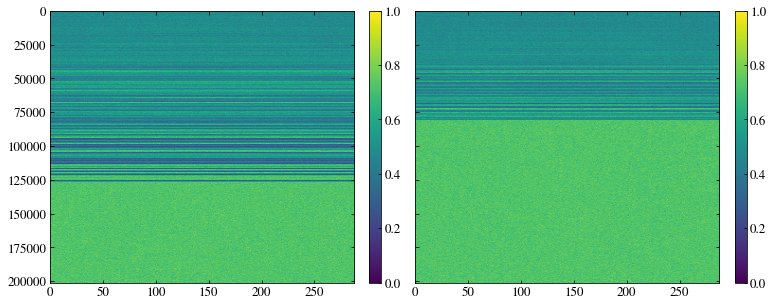

In [42]:
U_len = 67
xs_up = torch.load('./frozen/LR2_field_up_5.dat')
xs_dn = torch.load('./frozen/LR2_field_dn_5.dat')

fig, ax = plt.subplots(1,2, figsize = (12, 5), sharey=True)
im0 = ax[0].imshow(xs_up.reshape(U_len*s_num*t_len, 288), aspect='auto')
ca0 = inset_axes(ax[0], width="5%", height="100%", loc='center left',\
                bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[0].transAxes, borderpad=0)
cd = plt.colorbar(im0, cax=ca0)
im1 = ax[1].imshow(xs_dn.reshape(U_len*s_num*t_len, 288), aspect='auto')
ca1 = inset_axes(ax[1], width="5%", height="100%", loc='center left',\
                bbox_to_anchor=(1.05, 0., 0.8, 1), bbox_transform=ax[1].transAxes, borderpad=0)
cd = plt.colorbar(im1, cax=ca1)
#plt.savefig(f'fig/{modelname}_result.png')

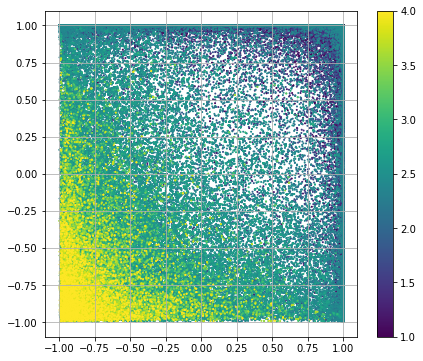

In [63]:
plt.figure(figsize=(7,6))
plt.scatter(test_mu[:,0], test_mu[:,1], s=1, c=U)
plt.colorbar()
plt.grid()
plt.show()